In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os

#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline

import seaborn as sns; sns.set_context('notebook')

from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

try:
    tf.compat.v1.enable_eager_execution()
except ValueError:
    pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Coin-flip example 
- (https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb)

Every statistics text must contains a coin-flipping example, I'll use it here to get it out of the way. Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50%). You believe there is some true underlying ratio, call it p, but have no prior opinion on what p might be.

We begin to flip a coin, and record the observations: either H or T. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips), while also demonstrating some of the best practices when it comes to evaluating tensors and plotting the data. First, the easy part: We define the values in our Tensorflow graph

In [2]:
# Build Graph
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

num_trials = tf.constant([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])

# prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data,tf.constant([[1, 0,]]),"CONSTANT")

# compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trials intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.to_float(1 + cumulative_headcounts),
    concentration0=tf.to_float(1 + num_trials - cumulative_headcounts))

probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))

Instructions for updating:
Use tf.cast instead.


In [3]:
# Execute graph
[num_trials_,
probs_of_heads_,
observed_probs_heads_,
cumulative_headcounts_,
] = evaluate([
  num_trials,
  probs_of_heads,
  observed_probs_heads,
  cumulative_headcounts
])

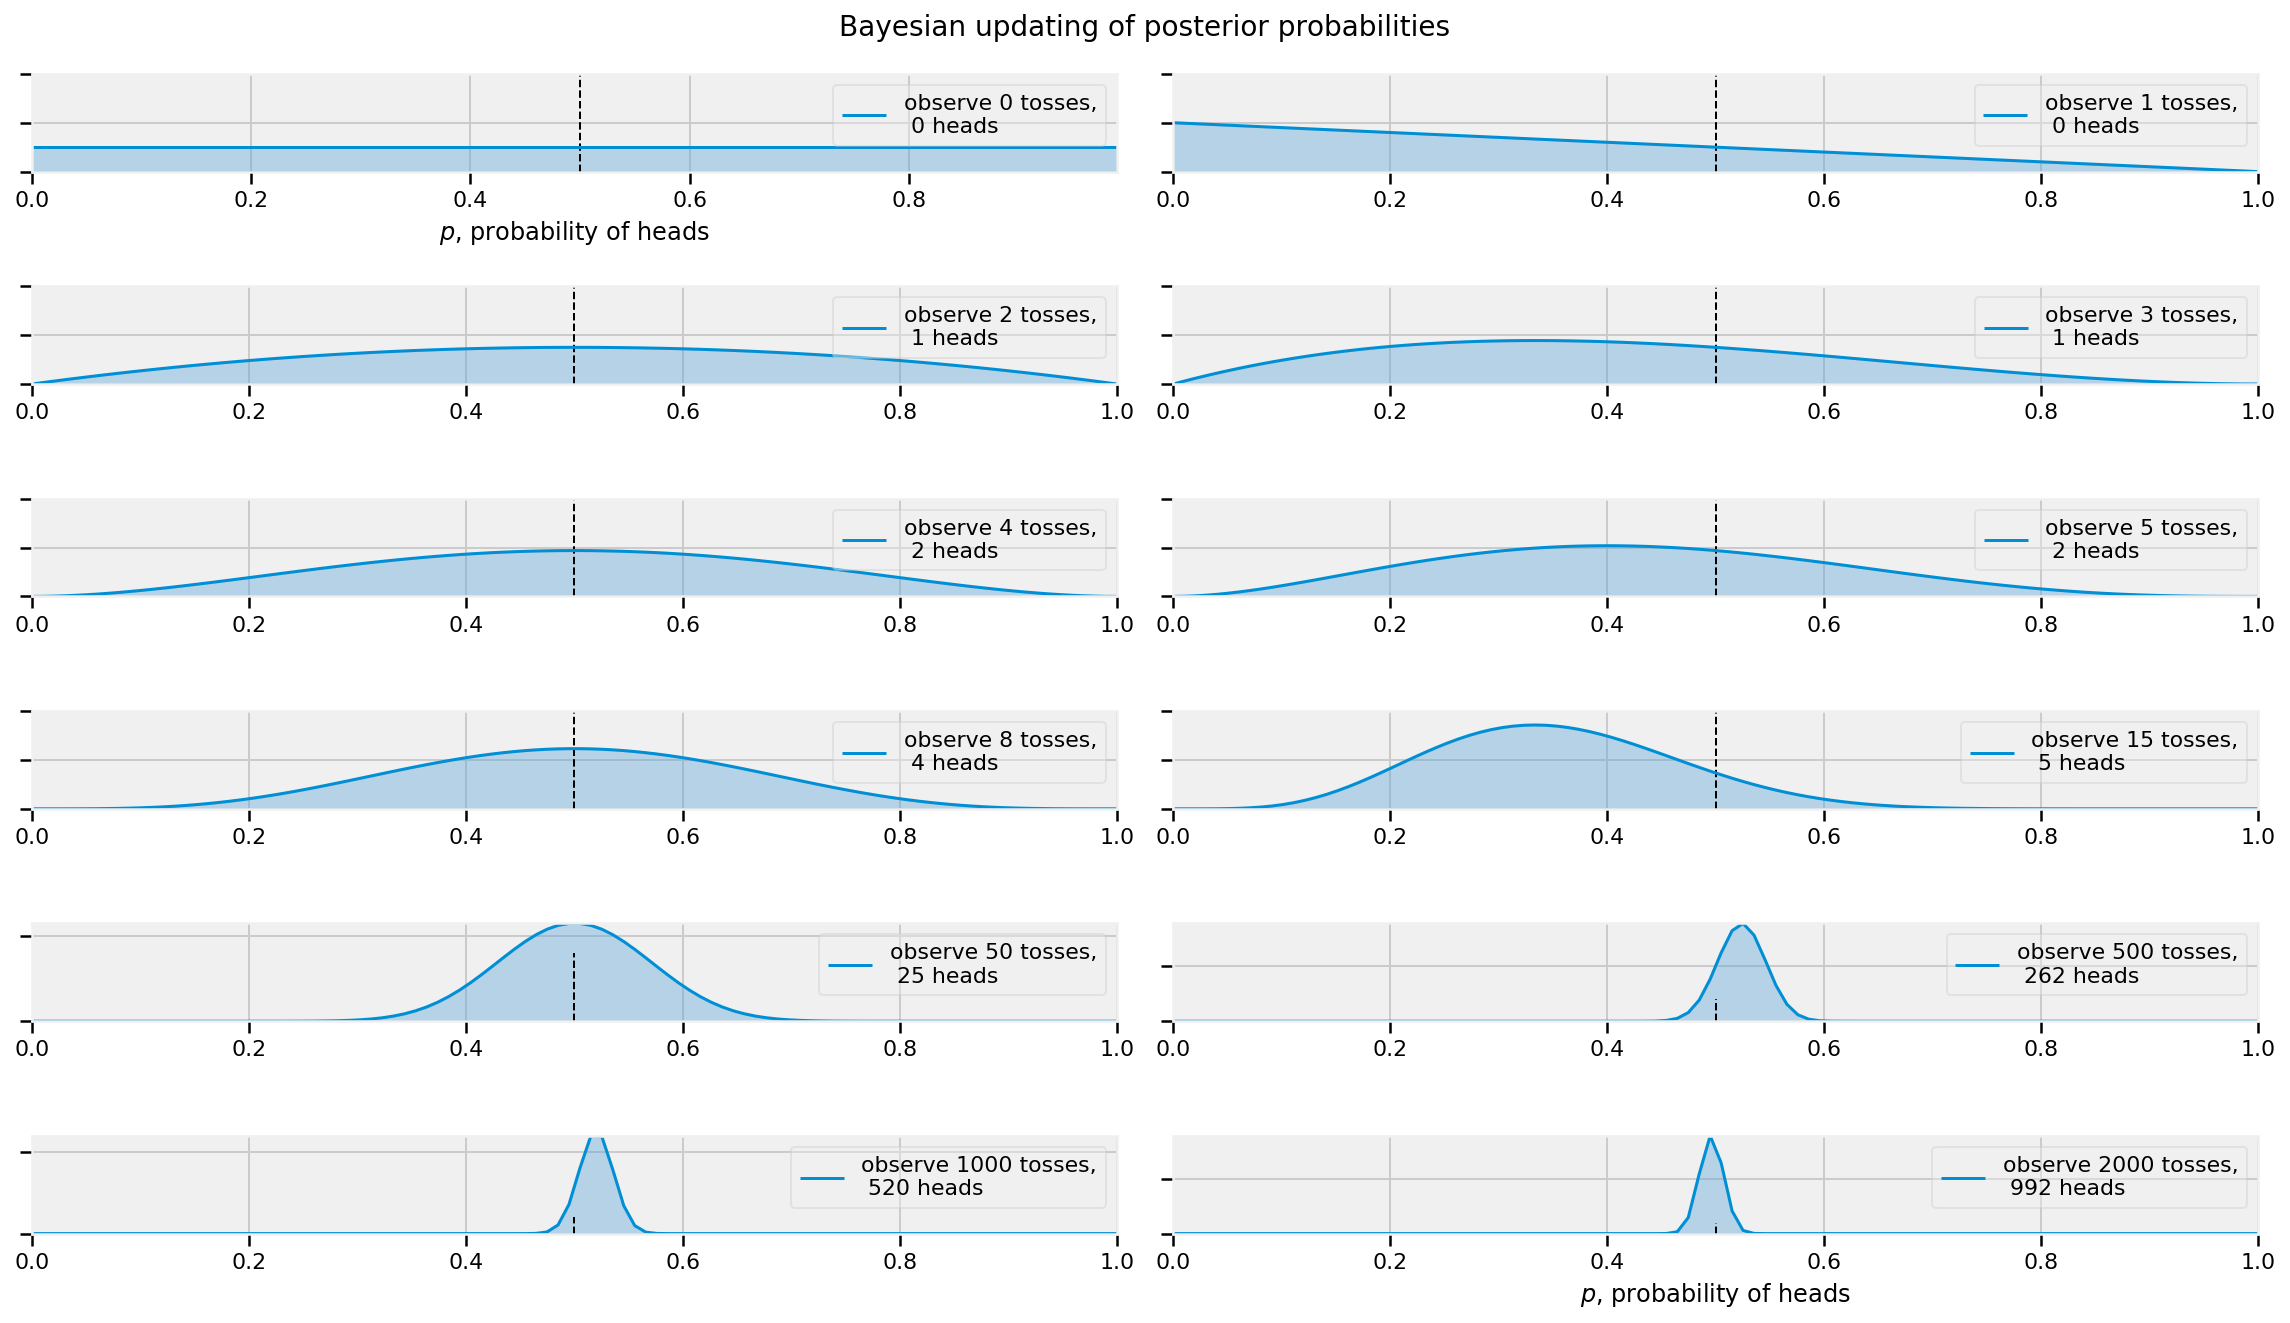

In [4]:
# I'm using Binomial's conj. prior.
plt.figure(figsize(16, 9))
for i in range(len(num_trials_)):
    sx = plt.subplot(len(num_trials_)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(num_trials_)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads_, observed_probs_heads_[i], 
             label="observe %d tosses,\n %d heads" % (num_trials_[i], cumulative_headcounts_[i]))
    plt.fill_between(probs_of_heads_, 0, observed_probs_heads_[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()